# Naive and baseline models

We are training and testing in this notebook the naive and the baseline models (logistic regression, support vector machine, random forest...) that could be used for the road segmentation. These models will obviously not give the best results but it is important to evaluate how good they are doing to have an overview on their performances.

Here are some useful packages that will be used :

In [6]:
from helpers_loading import *
from helpers_submission import *
from helpers_visualization import *

from BaselineModel import *

%load_ext autoreload
%autoreload 2

%matplotlib inline  

Finally we are loading the training and the testing sets once for all :

In [7]:
X, Y = load_training_set()

X_test = load_testing_set()

## Naive model

The naive model consists in predicting 0 (ground) for every single patch of any image because there is more ground than roads. Let's calculate it more precisely :

In [4]:
Y_labels = patches_to_labels(extract_patches(Y))

In [5]:
print('Only {}% of the labels are roads'.format(round(Y_labels.mean(), 2)))

Only 0.26% of the labels are roads


Thus we can expect an accuracy score of about **74%** on Kaggle by sending only black images. In practice we get **0.73024%**.

## Logistic regression

In this section we are tuning the unique parameter of the logistic regression, namely C, the regularization parameter. We are using the classic cross validation method to do so.

In [6]:
from sklearn.linear_model import LogisticRegression

### Cross validation

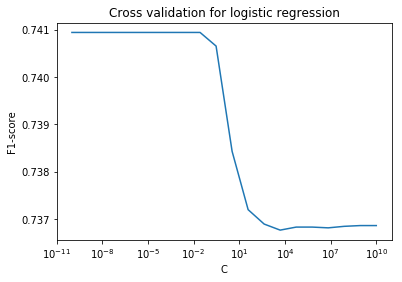

In [7]:
c_list = np.logspace(-10, 10, 20)
scores = []

for c in c_list:
    model = LogisticRegression(C=c)
    model = BaselineModel(model)
    score = np.mean(model.cross_validation(X, Y))
    scores.append(score)

plt.title('Cross validation for logistic regression')
plt.xlabel('C')
plt.ylabel('F1-score')
plt.semilogx(c_list, scores)

In [8]:
c_tuned = c_list[np.argmax(scores)]
print('The optimal C parameter found is : ' + str(c_tuned))

The optimal C parameter found is : 1e-10


### Predictions

We are here making the predictions for the test set and the submission file for Kaggle.

In [9]:
model = LogisticRegression(C=c_tuned)
model = BaselineModel(model)

model.train(X, Y)

Y_test = model.predict(X_test)

Let's visualize how good the predictions are :

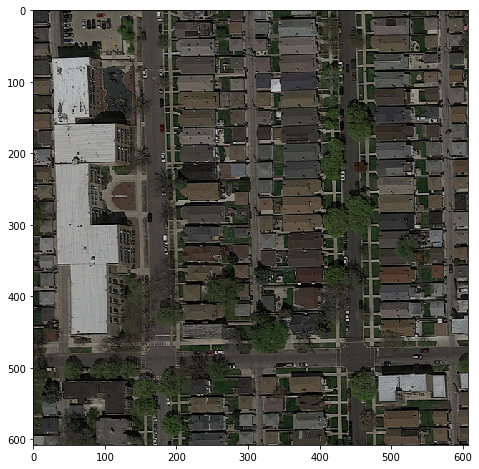

In [10]:
idx = 35

visualize_overlay(X_test[idx], Y_test[idx])

### Submission

In [11]:
submission_filename = 'submission_logreg.csv'

make_submission(Y_test, submission_filename)

## Support vector machine

In [8]:
from sklearn.svm import SVC

### Cross validation

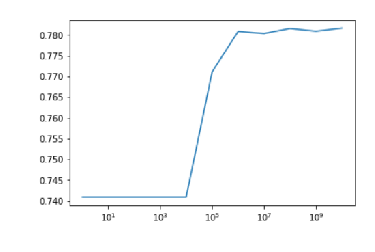

In [3]:
c_list = np.logspace(-10, 10, 30)
scores = []

for c in c_list:
    model = SVC(C=c)
    model = BaselineModel(model)
    score = np.mean(model.cross_validation(X, Y))
    scores.append(score)
    
plt.title('Cross validation for SVM')
plt.xlabel('C')
plt.ylabel('F1-score')
plt.semilogx(c_list, scores)

In [5]:
c_tuned = c_list[np.argmax(scores)]
print('The optimal C parameter found is : ' + str(round(c_tuned, 2)))

The optimal C parameter found is : 1.26e8


### Predictions

In [11]:
model = SVC(C=c_tuned)
model = BaselineModel(model)

model.train(X, Y)

Y_test = model.predict(X_test)

Let's visualize how good the predictions are :

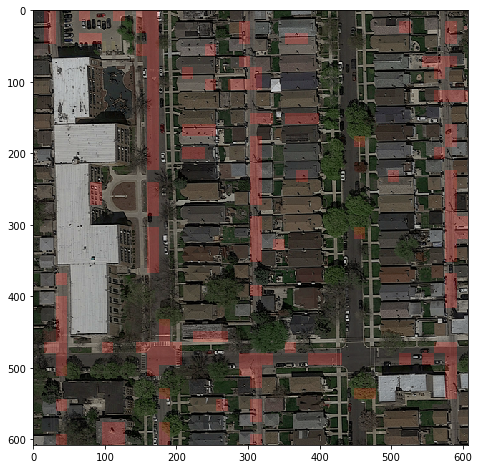

In [12]:
idx = 35

visualize_overlay(X_test[idx], Y_test[idx])

### Submission

In [13]:
submission_filename = 'submission_svm.csv'

make_submission(Y_test, submission_filename)

Giving 0.78481 on Kaggle

## Random forest

In [14]:
from sklearn.ensemble import RandomForestClassifier

### Cross validation

Since there are quite a lot of parameters to optimize for the random forest model, we decided to use a grid search embedded with a cross validation to find the best parameters. Since this operation is pretty long, we use a number of estimators of 10 for the parameter search and then increase this number for the training.

In [15]:
from sklearn.model_selection import GridSearchCV

In [16]:
max_features = np.array([None, 'log2', 'sqrt', 'auto'])
criterion = np.array(['gini', 'entropy'])
min_samples_leaf = np.array(np.arange(1, 40))
max_depth = np.array([1, 2, 4, 8, 16, 24, 32, 40, None])

model = RandomForestClassifier(n_estimators=10)

grid = GridSearchCV(estimator=model, scoring='f1_micro', cv=10,
                    param_grid=dict(max_features=max_features,
                                    criterion=criterion,
                                    min_samples_leaf=min_samples_leaf,
                                    max_depth=max_depth)
                   )
grid.fit(X, Y)

In [ ]:
print('The best score of the grid search was : ' + str(grid.best_score_))
print('Best max_features : None')
print('Best criterion : gini')
print('Best min_samples_leaf : 10')
print('Best max_depth : 16)

In [ ]:
print('The best score of the grid search was : ' + str(grid.best_score_))
print('Best max_features : ' + str(grid.best_estimator_.max_features))
print('Best criterion : ' + str(grid.best_estimator_.criterion))
print('Best min_samples_leaf : ' + str(grid.best_estimator_.min_samples_leaf))
print('Best max_depth : ' + str(grid.best_estimator_.max_depth))

### Predictions

In [18]:
grid.best_estimator_
model.n_estimators = 500
model = BaselineModel(model)

model.train(X, Y)

Y_test = model.predict(X_test)

Let's visualize how good the predictions are :

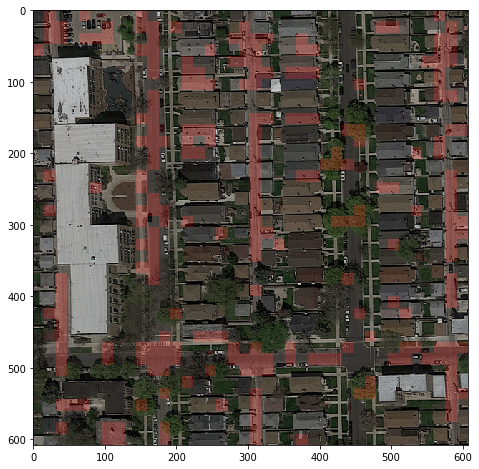

In [19]:
idx = 35

visualize_overlay(X_test[idx], Y_test[idx])

### Submission

In [20]:
submission_filename = 'submission_forest.csv'

make_submission(Y_test, submission_filename)

Gives 0.78537 on Kaggle